# Wafer Defect Detection with Machine Learning

Xi Chen

Novemver 15, 2021

## 1. Introduction

The semiconductor industry is developing rapidly. Data science and machine learning techniques are being utilized to detect defetcs and to better control their processes in semiconductor manufacturing. In this project, we will demonstrate how data science can be used in wafer fabrication to uncover defect patterns through analyzing wafer defect data.

### 1.1. Background

A die, in the context of semiconductors, is a small block of the wafer on which a given functional circuit is fabricated. The wafer is cut (diced) into many pieces, each containing one copy of the circuit. Each of these pieces is called a die.

In [1]:
# Show wafer bin map example from the internet

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.disco.co.jp/eg/introduction/img/what_pc.png", width=600)

The semiconductor manufacturing process begins with the production of silicon wafers, which serve as substrates for semiconductors. There are typically 25 wafers per lot. These wafers are then polished to a mirror finish before going through the wafer fabrication process to form circuits on the substrate wafer. These prepared wafers then go through wafer testing to test their functionality. 

Semiconductor failure can occur at any step during the manufacturing process. Such failures are usually caused by human mistakes, particles from equipment, chemical stains, etc. Each type of wafer failure occurs for different reasons during the manufacturing process. For example, Scratch is caused by machine handling, while Center and Edge-Ring are caused by thin film deposition and etching problems, respectively. Hence, it is necessary to accurately detect wafer map failure types during the semiconductor manufacturing process so that appropriate corrective and preventative measures can be taken.

Once the wafers are tested, a **wafer bin map (WBM)** is produced to provide information regarding the quality of a wafer and which dies have failed. Typically, experienced process engineers are able to define wafer failure pattern types. The wafers are then sliced and sorted to filter out the faulty dies. Functional dies are then packaged and the completed integrated circuit is ready to be shipped. **Yield** is a quantitative measure of the quality of a semiconductor process. It is the fraction of dies on the yielding wafers that are not discarded during the manufacturing process. 

The recognition of the wafer map failure pattern types is typically conducted by experienced semiconductor engineers for the detection of the actual causes of semiconductor failure. However, this entire process is expensive and time-consuming. To recognize wafer map failure types more efficiently, various machine learning (ML)-based approaches have been developed, supervised an unsupvised. In addition, several different classification models based on convolutional neural networks (CNN) have also been used to recognize the failure types of wafer maps. These models were generated by taking the wafer map image as the input and then deciding the wafer map failure types as the output of the models. 

### 1.2. Objective

This project will experiment with three multi-class classification models for the automatic recognition of wafer map failure pattern types during semiconductor manufacturing processes on the basis of real wafer map image data. Three popular ML-based models are selected: 
- Support vector machine (SVM)
- Logistic regresson (LR)
- Random foreast classifier

To demonstrate the performance of our proposed model, we compare the three propased model each other to see which one has the best performance.

The objective of this project is to correctly indetify die failure patterns on a wafer. The identified defect patterns are used by engineers and subject matter experts to tied back to the process variables for root cause analysis so that appropriate corrective and preventative actions can be taken to improve yield. Analyzing the WBMs manually is an extremely time consuming process; it also leads to a high margin of error if the manually examined subsample is not representative of the entire lot of WBMs. Therefore, using machine learning to identify die failure patterns will reduce manual work, and ealy detection saves wasted materials and effort.

## 2. Dataset Description

### 2.1. Data Source

The experiment is conducted using the real-time wafer map dataset WM-811K. The data is available on Kaggle: https://www.kaggle.com/qingyi/wm811k-wafer-map. This is a public dataset from the Multimedia Information Retrieval (MIR) lab (http://mirlab.org/dataset/public/).

This dataset contains 811,457 wafer maps collected from 46,393 lots in real-world fabrication. The dataset includes nine regular wafer map failure pattern types: Center, Donut, Local, Edge-Local, Edge-Ring, Scratch, Random, Near-Full, and None.

### 2.2. Data Attributes

In [2]:
# Read data file

import pandas as pd
df = pd.read_pickle("./data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


The dataset contains additional information on the wafer maps such as wafer die size, lot name and wafer index (25 wafers per lot).

The training/test sets have already been split by domain experts in this dataset, but these labels will be ignored.

## 3. Exploratory Data Analysis

In [3]:
# Import libraries

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random

In [4]:
# Show sample of dataset

df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


The waferMap column contains the wafer bin map, pixel by pixel. For simplicity, each die on the WBM is considered failed if it fails for at least one test, and otherwise it is considered functional. If a die on a wafer fails, it is marked as 2 or it is marked 1 if it passes. Therefore, each pixels has a categorical variable that expresses
- 0 : not wafer
- 1 : normal
- 2 : faulty

The waferIndex column indicates the index of the wafer in a 25-wafer lot. Because of this, we will change the type of "waferIndex" to interger. Also changing the column "trianTestLabel" to the correct spelling.

In [5]:
# Correct columns

df.rename(columns={'trianTestLabel':'trainTestLabel'}, inplace=True)
df.waferIndex = df.waferIndex.astype(int)
df.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2,[],[]


From the "lotName" column, the dataset is collected from 47,543 lots. However, 47,543 lots x 25 wafer/lot = 1,157,325 wafer maps, which is greater than 811,457 wafer maps. I suspect that not all lots have 15 wafers; the last lot only has 2.

Let's see what happened.

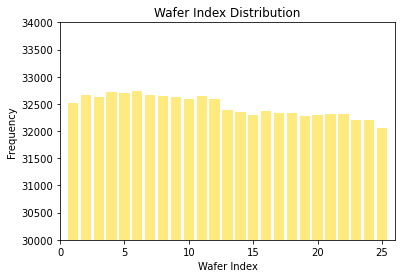

In [6]:
# Visualize wafer index distribution

uni_Index = np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title("Wafer Index Distribution")
plt.xlabel("Wafer Index")
plt.ylabel("Frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

The figure shows that not all lots have perfect 25 wafer maps. Fortunately, we do not need wafer index feature in our classification, so we can just drop the variable.

In [7]:
# Drop column for wafer index

df = df.drop(['waferIndex'], axis = 1)

From the "dieSize" column, we can see that die size for each instance is different.

We create a new variable 'waferMapDim' for checking the dimension of the wafer maps.

In [8]:
# Add column for wafer map dimension

def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
676110,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2,...",592.0,lot42053,[[Test]],[[none]],"(29, 27)"
708224,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43355,[[Training]],[[none]],"(25, 27)"
443467,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",733.0,lot27124,[],[],"(31, 31)"
434434,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot26288,[],[],"(35, 40)"
389167,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3878.0,lot23337,[],[],"(88, 56)"


In [9]:
# Wafer dimension distribution

#max(df.waferMapDim), min(df.waferMapDim)
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
#uni_waferDim[0].shape[0]
df['waferMapDim'].value_counts(normalize = True)

(32, 29)      0.133941
(25, 27)      0.078973
(49, 39)      0.048460
(26, 26)      0.037067
(30, 34)      0.036370
                ...   
(39, 69)      0.000001
(104, 116)    0.000001
(40, 50)      0.000001
(24, 18)      0.000001
(54, 64)      0.000001
Name: waferMapDim, Length: 632, dtype: float64

The dimension of wafer map, or the image size are not always the same. We see that there are 632 different size for our wafer map. There is a variety of different wafer map dimensions, and they are not all perfectly circular.

For this reason, we must do data tranformation (feature extraction) to normalize the input dim and the method will be introduced later.

We see that the columns "trianTestLabel" and "failureType" are not stored in the optimal data type. Since this is a large dataset, I will inspect the data types and memory usage to see where we can use more memory efficient data types.

In [10]:
# Dataframe memory usage

df.memory_usage(deep = True)  # memory usage in bytes

Index                   128
waferMap          340512546
dieSize             6491656
lotName            78547197
trainTestLabel    101011720
failureType       100465088
waferMapDim        38949936
dtype: int64

Making a copy of the dataset and cleaning up the last two columns.

In [11]:
# Create a copy of dataset

df2 = df.copy()
df2.failureType = df2.failureType.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2.trainTestLabel = df2.trainTestLabel.apply(lambda x: x[0][0] if len(x) > 0 else float("NaN"))
df2.sample()

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
280477,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6052.0,lot17204,NaN,NaN,"(86, 89)"


In [12]:
# Check new dataset memory usage

df2.memory_usage(deep = True)

Index                   128
waferMap          340512546
dieSize             6491656
lotName            78547197
trainTestLabel     36733994
failureType        36597336
waferMapDim        38949936
dtype: int64

Now the new columns take up significantly less memory (37,000k vs 100,000k). The columns "trainTestLabel" and "failureType" have just a few unique values, so they are a good candidates for converting to Categoricals. With Categoricals, we store each unique name once and use space-efficient integers to know which specific name is used in each row.

In [13]:
# Cast categorical columns

df2['trainTestLabel'] = df2['trainTestLabel'].astype('category')
df2['failureType'] = df2['failureType'].astype('category')
df2.memory_usage(deep = True)

Index                   128
waferMap          340512546
dieSize             6491656
lotName            78547197
trainTestLabel       811727
failureType          812635
waferMapDim        38949936
dtype: int64

<AxesSubplot:ylabel='failureType'>

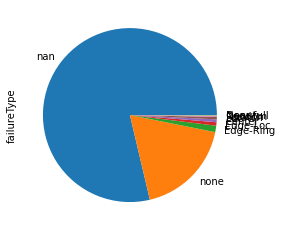

In [14]:
# Check falure type distribution

df2['failureType'].value_counts(dropna = False, normalize = True).plot.pie()

In [15]:
# Check failure type distribution of wafers with non-null labels

#df2['failureType'].value_counts().plot.bar()
df2['failureType'].value_counts()

none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: failureType, dtype: int64

In [16]:
# Check total number of images with non-null labels

df2['failureType'].value_counts().sum()

172950

We can also see that out of the entire dataset, only 172,950 images with manual labels (in total 9 labels: none, Edge-Ring, Edge-Loc, Center, Loc, Scratch, Random, Donut, and Near-full). 78.7% wafers have no label based on the failureType attribute. Among labeled wafers, only ~15% wafers (25,519 wafers) have real failure patterns while 147,431 wafers were still labeled none.

From the 172,950 images, the none pattern occupies 85.2%. The dataset is **imbalanced**. The ‘Near-Full’ class only contains 149 images. Hence, we are removing the ‘Near-Full’ class from our experimental data and focusing on other eight wafer map failure pattern types. Also, we will use random sampling to extract 500 images from each of the eight classes from the original dataset to create a dataset consisting of a total of 4,000 images. Then, the dataset will be split into training data and test data in a proportion of 70% and 30%, respectively.

There are also a lot of missing values. Since we are only interested in wafers with patterns, we will remove those without failure type labels. This will signifacantly reduce dataset size.

Also adding two columns to encode the failure categories and train/test labels.

Due to the method for extracting density-based features, the wafer maps have to be at least 5x5. Applying a filter to remove wafer maps that are smaller than 5x5.

In [17]:
# Delete unlabeled data and "near-full" type

df2['failureNum'] = df2.failureType
df2['trainTestNum'] = df2.trainTestLabel
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest = {'Training':0,'Test':1}
df2 = df2.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

df2 = df2[(df2['failureNum']>=0) & (df2['failureNum']<=8)]
df2 = df2[(df2['failureType']!='Near-full')]
df2['failureType'] = df2['failureType'].cat.remove_unused_categories()

# Filter out filter maps that are too small

size_filter = [all(np.greater(df2['waferMapDim'].iloc[i], (5,5))) for i in range(len(df2))]
df2 = df2[size_filter]
df2.shape[0]

172799

In [18]:
# Generate new dataset with balanced classes

random.seed(10)
failure_types = list(df2['failureType'].cat.categories)
num_cat = len(failure_types)
df = pd.DataFrame()
for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    sample = df2.loc[df2['failureType'] == cat].sample(500)
    df = df.append(sample)
    
df['failureType'].value_counts()

none         500
Scratch      500
Random       500
Loc          500
Edge-Ring    500
Edge-Loc     500
Donut        500
Center       500
Name: failureType, dtype: int64

We will visualize the some wafer bin maps to see what the failure patterns look like. The dark purple region is the region that is not a wafer, the green color in the figure denotes that the die on the wafer has passed, while yellow denotes that the die has failed.

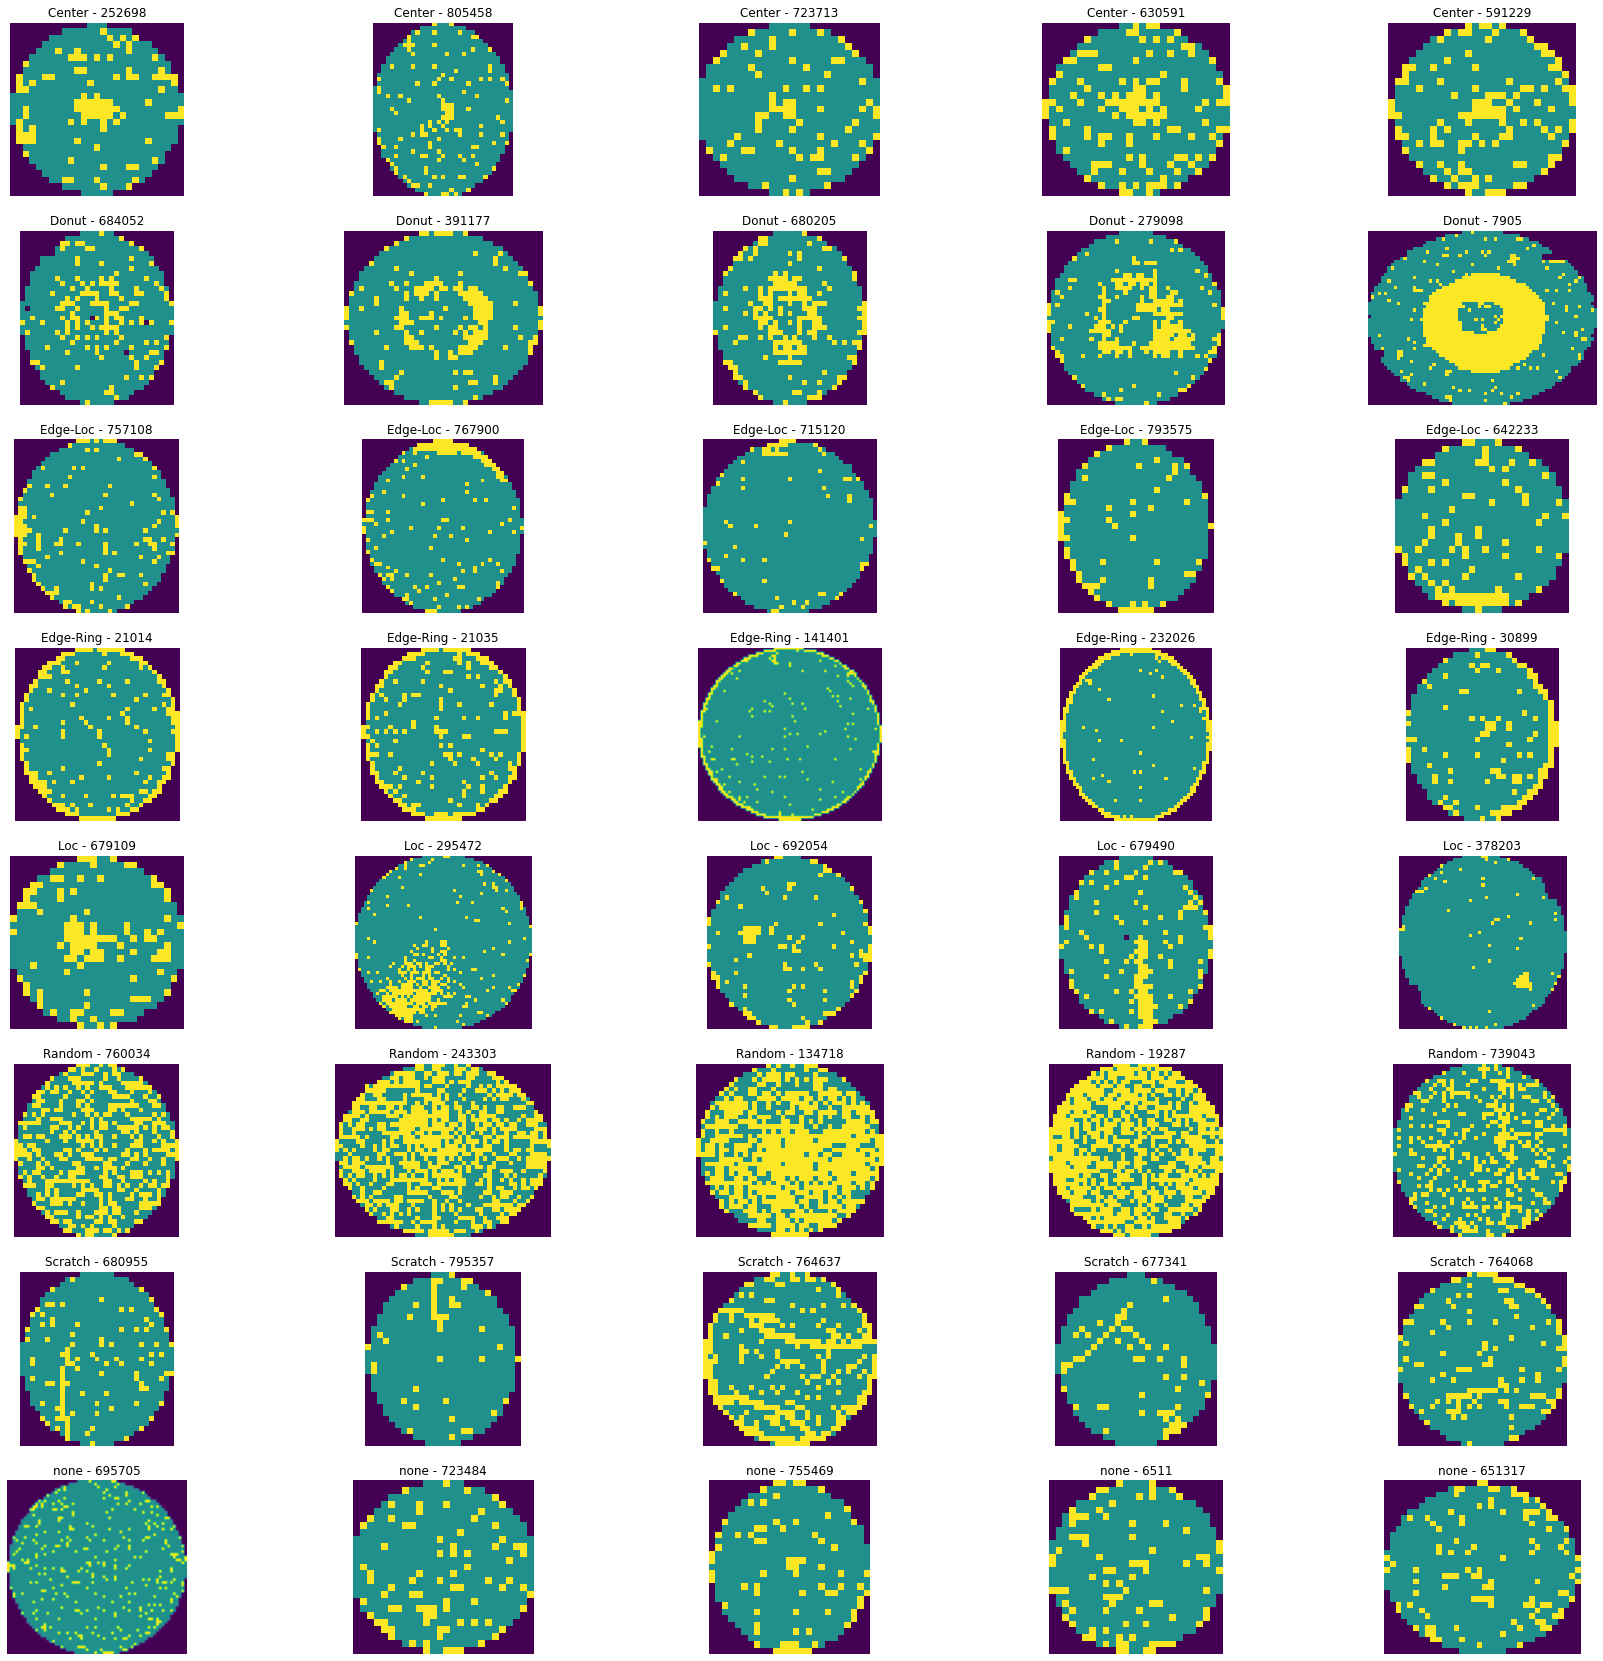

In [19]:
# Plot 5 of each failure type

sample_size = 5
fig, axs = plt.subplots(num_cat, sample_size, figsize = (30,30))
for i_cat in range(num_cat):
    cat = failure_types[i_cat]
    random.seed(10)
    sample = df2.loc[df2['failureType'] == cat].sample(sample_size)
    for i in range(len(sample)):
        index = sample.index[i]
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(sample['waferMap'][index])
        axs[i_cat, i].set_title(f'{cat} - {index}')

The figure above shows 5 random examples of each of the eight wafer map failure types. 

In [20]:
# Look at train/test split

df['trainTestLabel'].value_counts(dropna = False, normalize = True)

Training    0.59575
Test        0.40425
Name: trainTestLabel, dtype: float64

The dataset has already been split into a test set adn a training set by the MIR lab. However, after the resampling, we need to create a new train/test split. We will therefore ignore these lables and create a 70/30 train/test split later.

## 4. Data Pre-processing and Noise Reduction

Because the wafer map dimensions are different, we will apply data transformation to transform preprocessed data ready for machine learning by engineering features using scaling, attribute decomposition and attribute aggregation.

Since the objective of the work is to identify the pattern in the die failures instead of the individual failure points, it is important to reduce the noise and enhance the signal. To reduce the noise in the WBM, **median filtering** is used.

In [21]:
# loading libraries

from scipy import ndimage

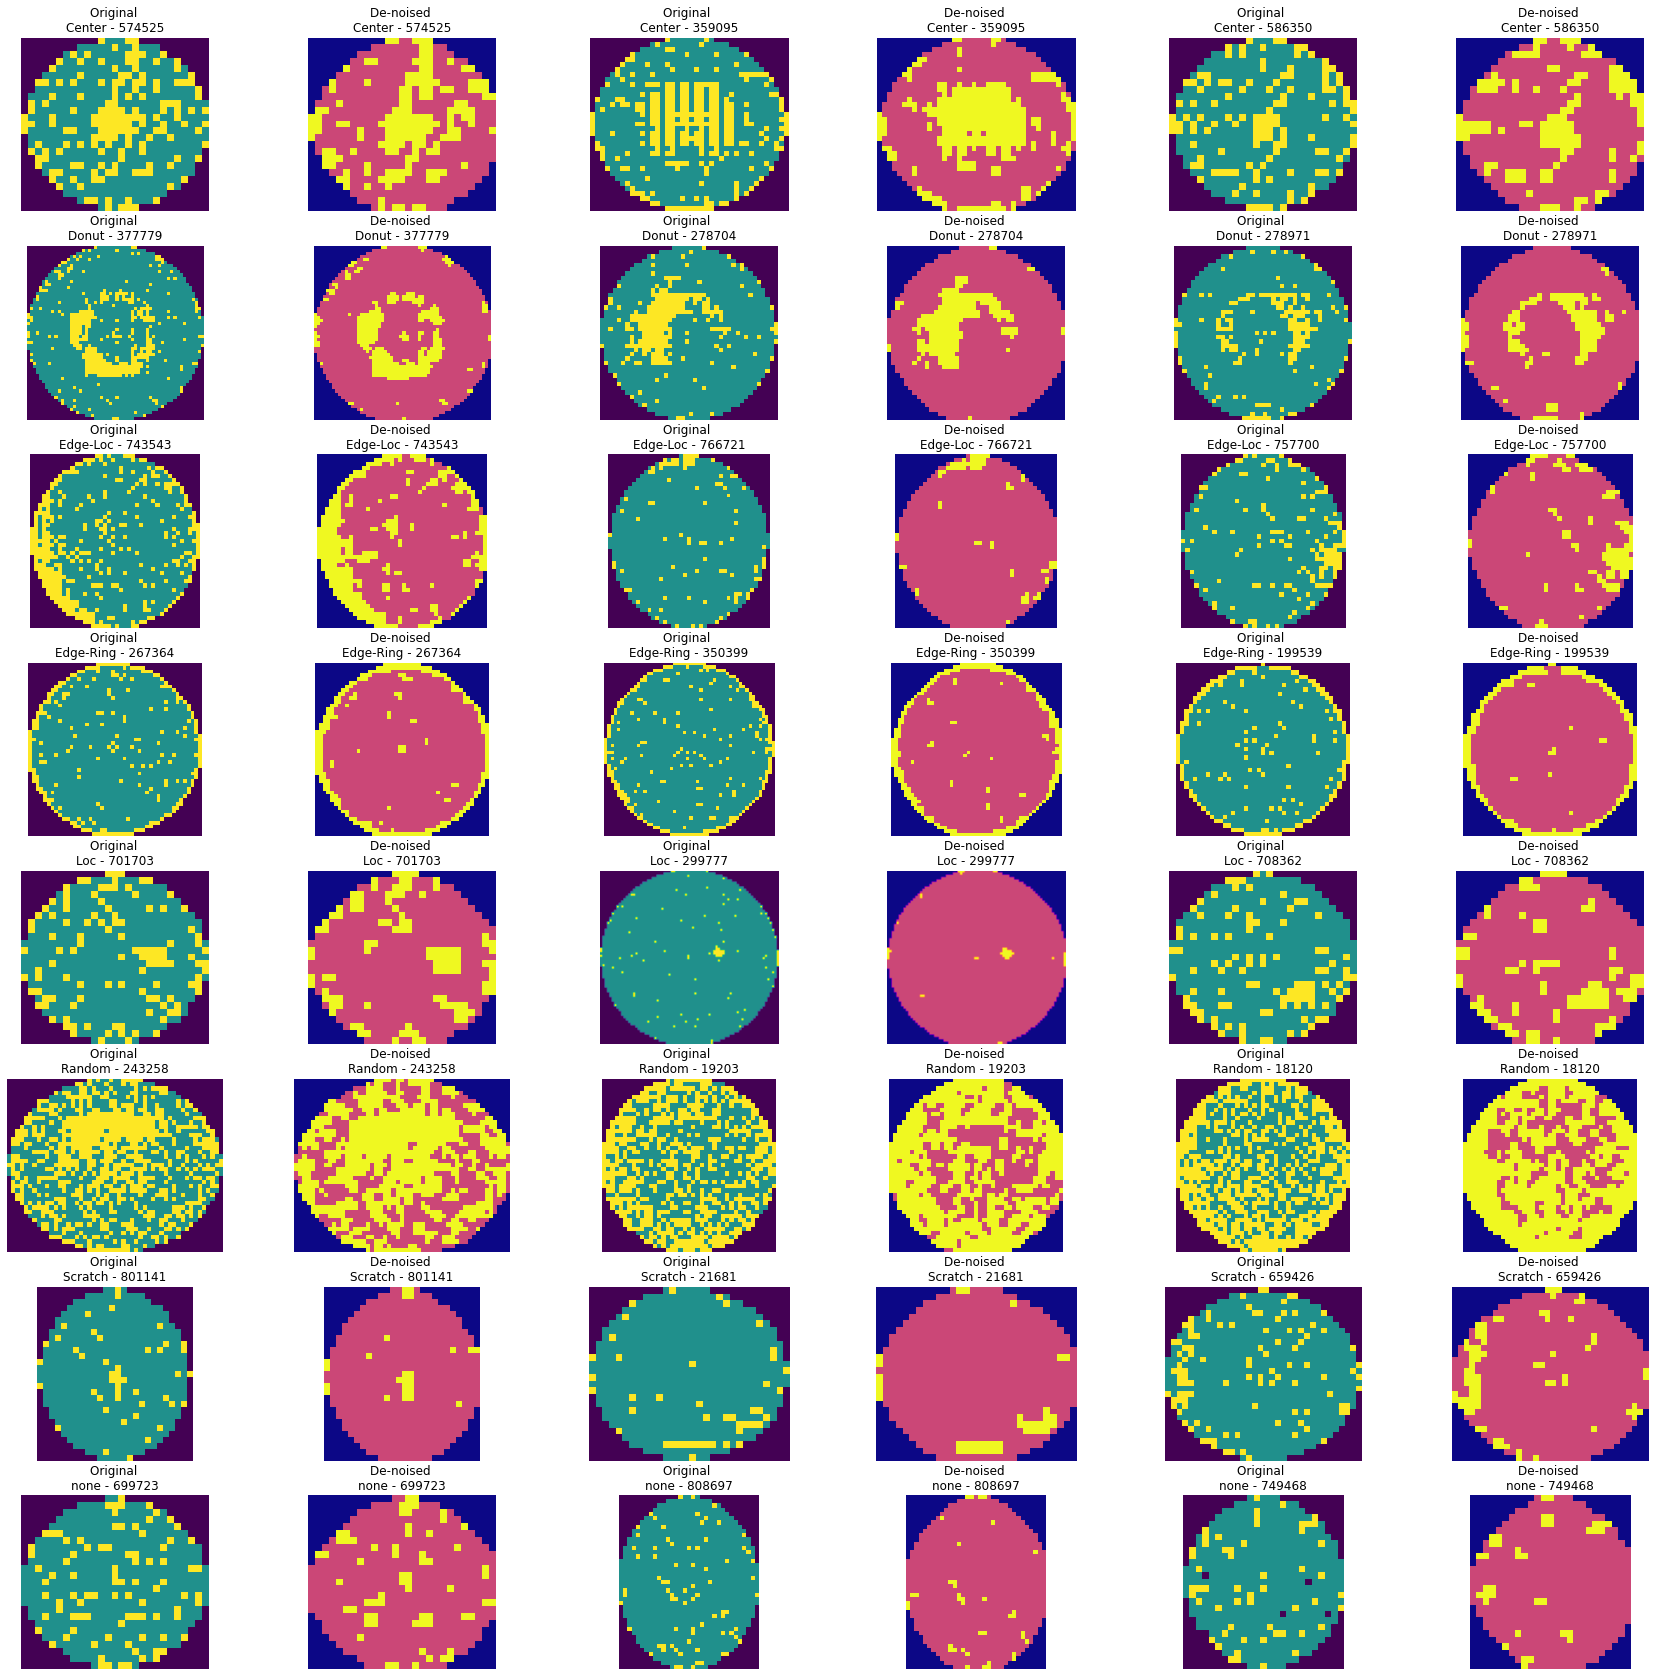

In [22]:
# Visualize denoising

#num_cat = len(df['failureType'].cat.categories)
sample_size = 3
fig, axs = plt.subplots(num_cat, sample_size * 2, figsize = (30,30))
for i_cat in range(num_cat):
    cat = df['failureType'].cat.categories[i_cat]
    random.seed(10)
    sample = df.loc[df['failureType'] == cat].sample(sample_size)
    for i in range(0, len(sample) * 2, 2):
        index = sample.index[int(i/2)]
        original = sample['waferMap'][index]
        denoised = ndimage.median_filter(original, size = (2,2))
        axs[i_cat, i].axis('off')
        axs[i_cat, i].imshow(original)
        axs[i_cat, i].set_title(f'Original \n{cat} - {index}')
        axs[i_cat, i + 1].axis('off')
        axs[i_cat, i + 1].imshow(denoised,  cmap=plt.get_cmap('plasma'))
        axs[i_cat, i + 1].set_title(f'De-noised \n{cat} - {index}')

The images above show comparisons of the original wafer map and the denoised ones. For ease of comparison, the are displayed side by side with a different color map.

In [23]:
# Apply denoising to entire dataset

import warnings
warnings.filterwarnings('ignore')
df3 = df.copy()
for i in range(len(df3['waferMap'])):
    original = df3['waferMap'].iloc[i]
    df3['waferMap'].iloc[i] = ndimage.median_filter(original, size = (2,2))

## 5. Feature Extraction

Once the wafers are denoised, the next step in the analysis is to extract features from the wafer bin maps. There will be 13 density based features, 40 Randon-based Features, and 6 geometry based features.

### 5.1. Density-based Features (13)

To create density-based features, the wafer bin map is divided into 13 regions. The 13 regions include the inner 3x3 region and the regions around the top, bottom, left, and right, edges of the wafer bin map like the figure shown below. The density of failure in each region is calculated as the percentage of "2" (failed die) in the region. These 13 features thus represent the position of die failures on the wafer. Each failure type will have different density distribution patterns. We can define it as follows:
- Center: failure type should should have the highest densities of failure in the region 9
- Donut: failure type should have the highest densities at the regions surrounding the dentral regions, like regions 5, 6, 7, 8, 10, 11, 12, and 13
- Edge-Local: one or more parts from 1 to 4 contained high defect density
- Edge-Ring: parts 1 to 4 contained high and equal defect density
- Local: several parts from 5 to 13 contained high defect density
- Random: each part contained almost similar defect density
- Scratch: random defect density distribution
- None: no specific defect density distribution in any part

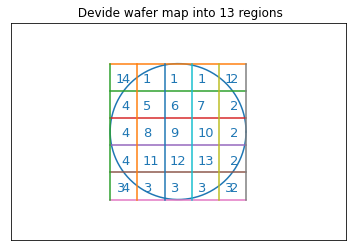

In [24]:
# Make the grid

an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
for i in range(6):
    plt.plot([-2.5, 2.5], [2.5 - i, 2.5 - i])
for i in range(6):
    plt.plot([2.5 - i, 2.5 - i], [-2.5, 2.5])

# Number the regions

for i in range(5):
    plt.text(-2.3 + i, 1.8, 1, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(1.9, 1.8 - i, 2, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(-2.3 + i, -2.2, 3, {'color': 'C0', 'fontsize': 13})
for i in range(5):
    plt.text(-2.1, 1.8 - i, 4, {'color': 'C0', 'fontsize': 13})
for row in range(3):    
    for i in range(3):
        plt.text(-1.3 + i, 0.8 - row, i + 5 + row * 3, {'color': 'C0', 'fontsize': 13})
    
plt.title(" Devide wafer map into 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [25]:
# Define functions to calculate densities of the regions

def cal_den(x):
    return 100 * (np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    #print(cols)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    reg1=x[ind1[0]:ind1[1],:]
    reg2=x[:,ind2[4]:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
        
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [26]:
# Apply the density calculation function

df3['fea_reg']=df3.waferMap.apply(find_regions)

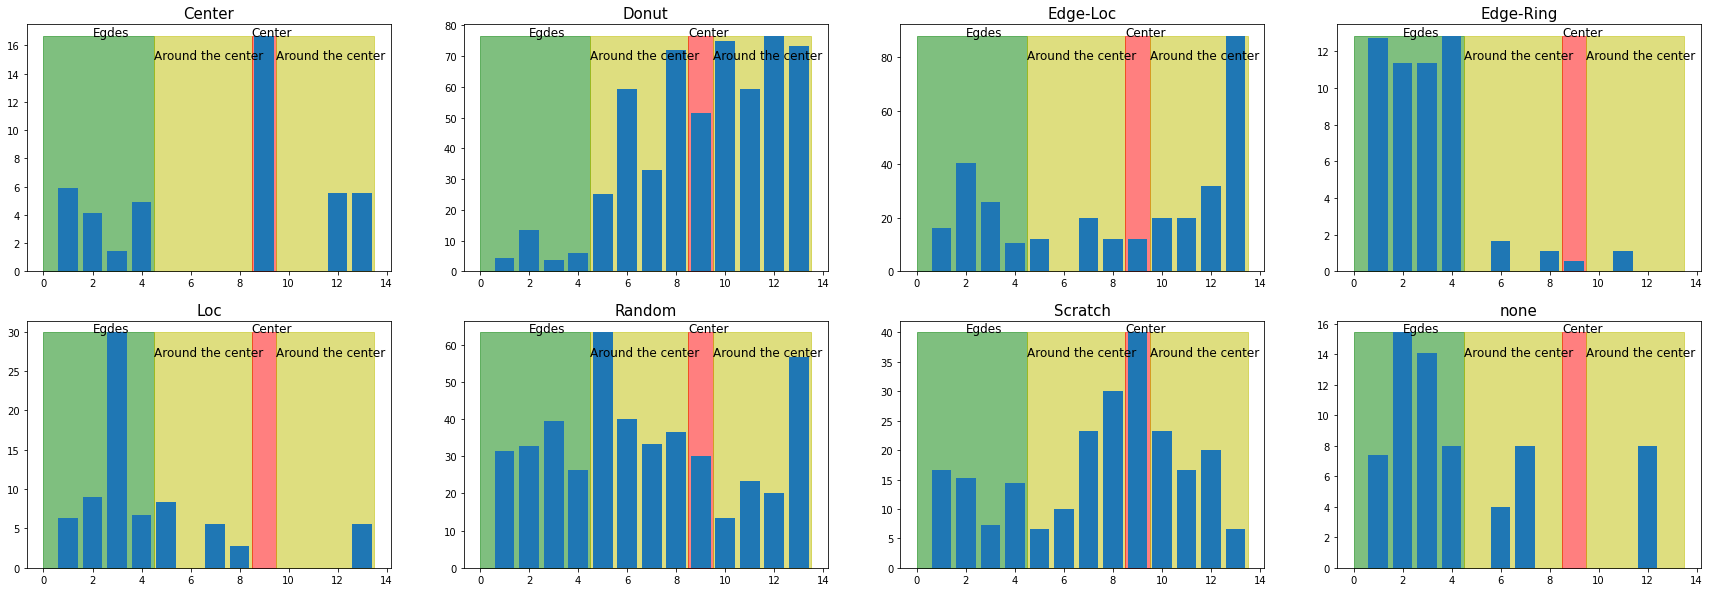

In [27]:
# Visualize the density distributions

sample_size = 1
fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (30,10))
axs = axs.ravel(order='C')
coordinates = [[()]]
for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    axs[i].bar(np.linspace(1,13,13), list(sample['fea_reg'])[0])
    axs[i].set_title(cat, fontsize=15)
    y_lim = max(list(sample['fea_reg'])[0])
    axs[i].fill_betweenx((0, y_lim), 0, 4.5, alpha=0.5, color = 'g')
    axs[i].fill_betweenx((0, y_lim), 4.5, 8.5, alpha=0.5, color = 'y')
    axs[i].fill_betweenx((0, y_lim), 8.5, 9.5, alpha=0.5, color = 'r')
    axs[i].fill_betweenx((0, y_lim), 9.5, 13.5, alpha=0.5, color = 'y')
    axs[i].text(2, y_lim, 'Egdes', {'color': 'k', 'fontsize': 12})
    axs[i].text(4.5, y_lim*0.9, 'Around the center', {'color': 'k', 'fontsize': 12})
    axs[i].text(8.5, y_lim, 'Center', {'color': 'k', 'fontsize': 12})
    axs[i].text(9.5, y_lim*0.9, 'Around the center', {'color': 'k', 'fontsize': 12})
    
plt.show()

The visualization above shows the 13 density based features for the 8 failure types.

From the graph above, we can see that the density based features have a distinct distribution for each failure type. The dataset seems classifiable.

### 5.2. Randon-based Features (40)

Randon-based features are based on the radon transform, which can generate a 2d representation of the wafer map according to a series of projections. Radon transform is the projection of the image angles. The projection is the sum of the intensities of the pixels in each direction, i.e., a radial line oriented at a specific angle. For more on Radon transform, refer to scikit-image page about Radon transform. The radon transform results for eight typical defect classes with random samples is shown in the figure below. 

In [28]:
# Change the 1s to 0s so that the wafer maps only contain two types of signals: faulty and not faulty

def change_val(img):
    img[img==1] = 0  
    return img

df3['new_waferMap'] = df3.waferMap.apply(change_val)

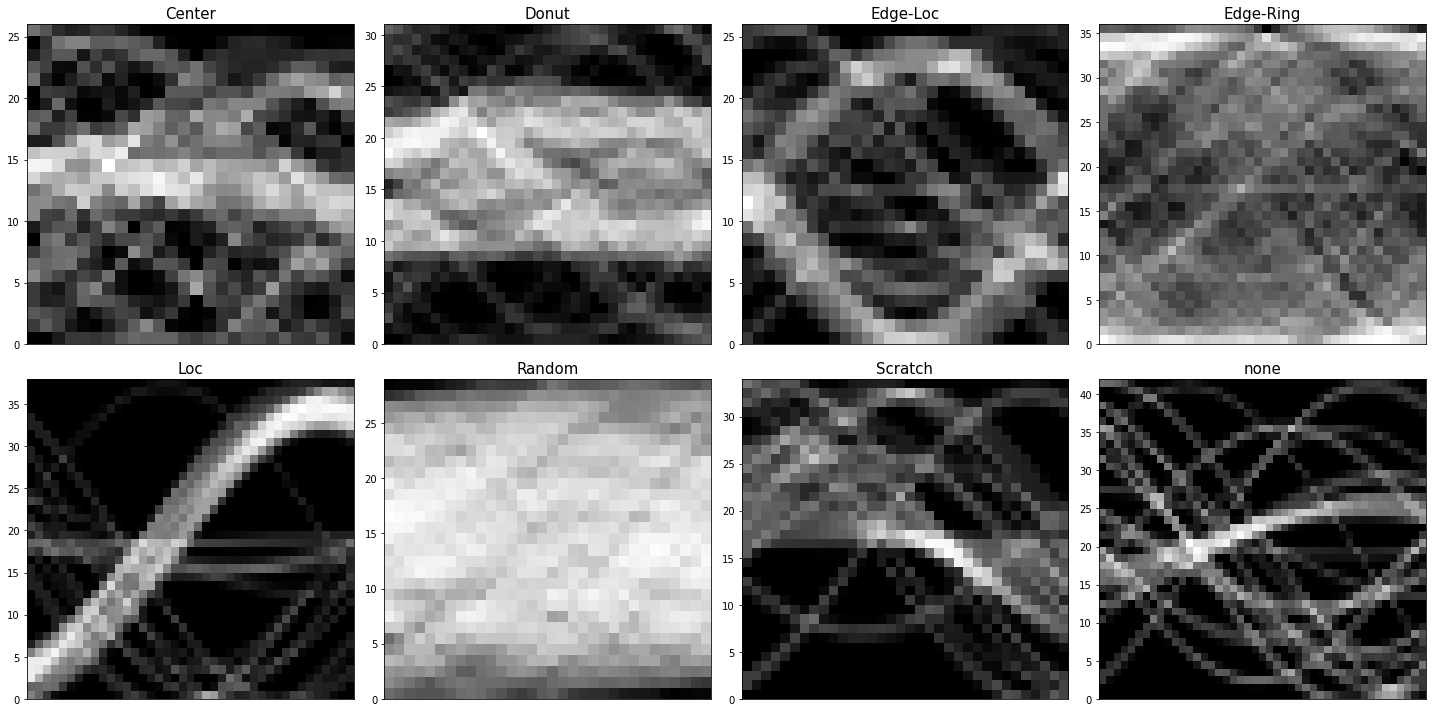

In [29]:
# Visualize randon transformation

from skimage.transform import radon

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    img = list(sample['waferMap'])[0]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(cat, fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

The picture above shows radon tranform results for 8 typical failure types.

However, because the wafers vary in size, we have to obtain fixed dimension features to use the radon transform values as features. In the next step, we use cubic interpolation to obtain fixed dimension feature values for row mean and row standard deviation from radon transform, and for each one the dimension is fixed to 20. We will extract twenty features from each dimension, so we have 40 radon-based features in total. The figure below shows radon-based features of row mean and row standard deviation for each defective class in selective samples.

For more on Cubic interpolation, refer to scikit-image page about Cubic interpolation.

In [30]:
# Define functions for cubis interpolation

from scipy import interpolate

def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [31]:
# Apply cubic interpolation

df3['fea_cub_mean'] = df3.waferMap.apply(cubic_inter_mean)
df3['fea_cub_std'] = df3.waferMap.apply(cubic_inter_std)

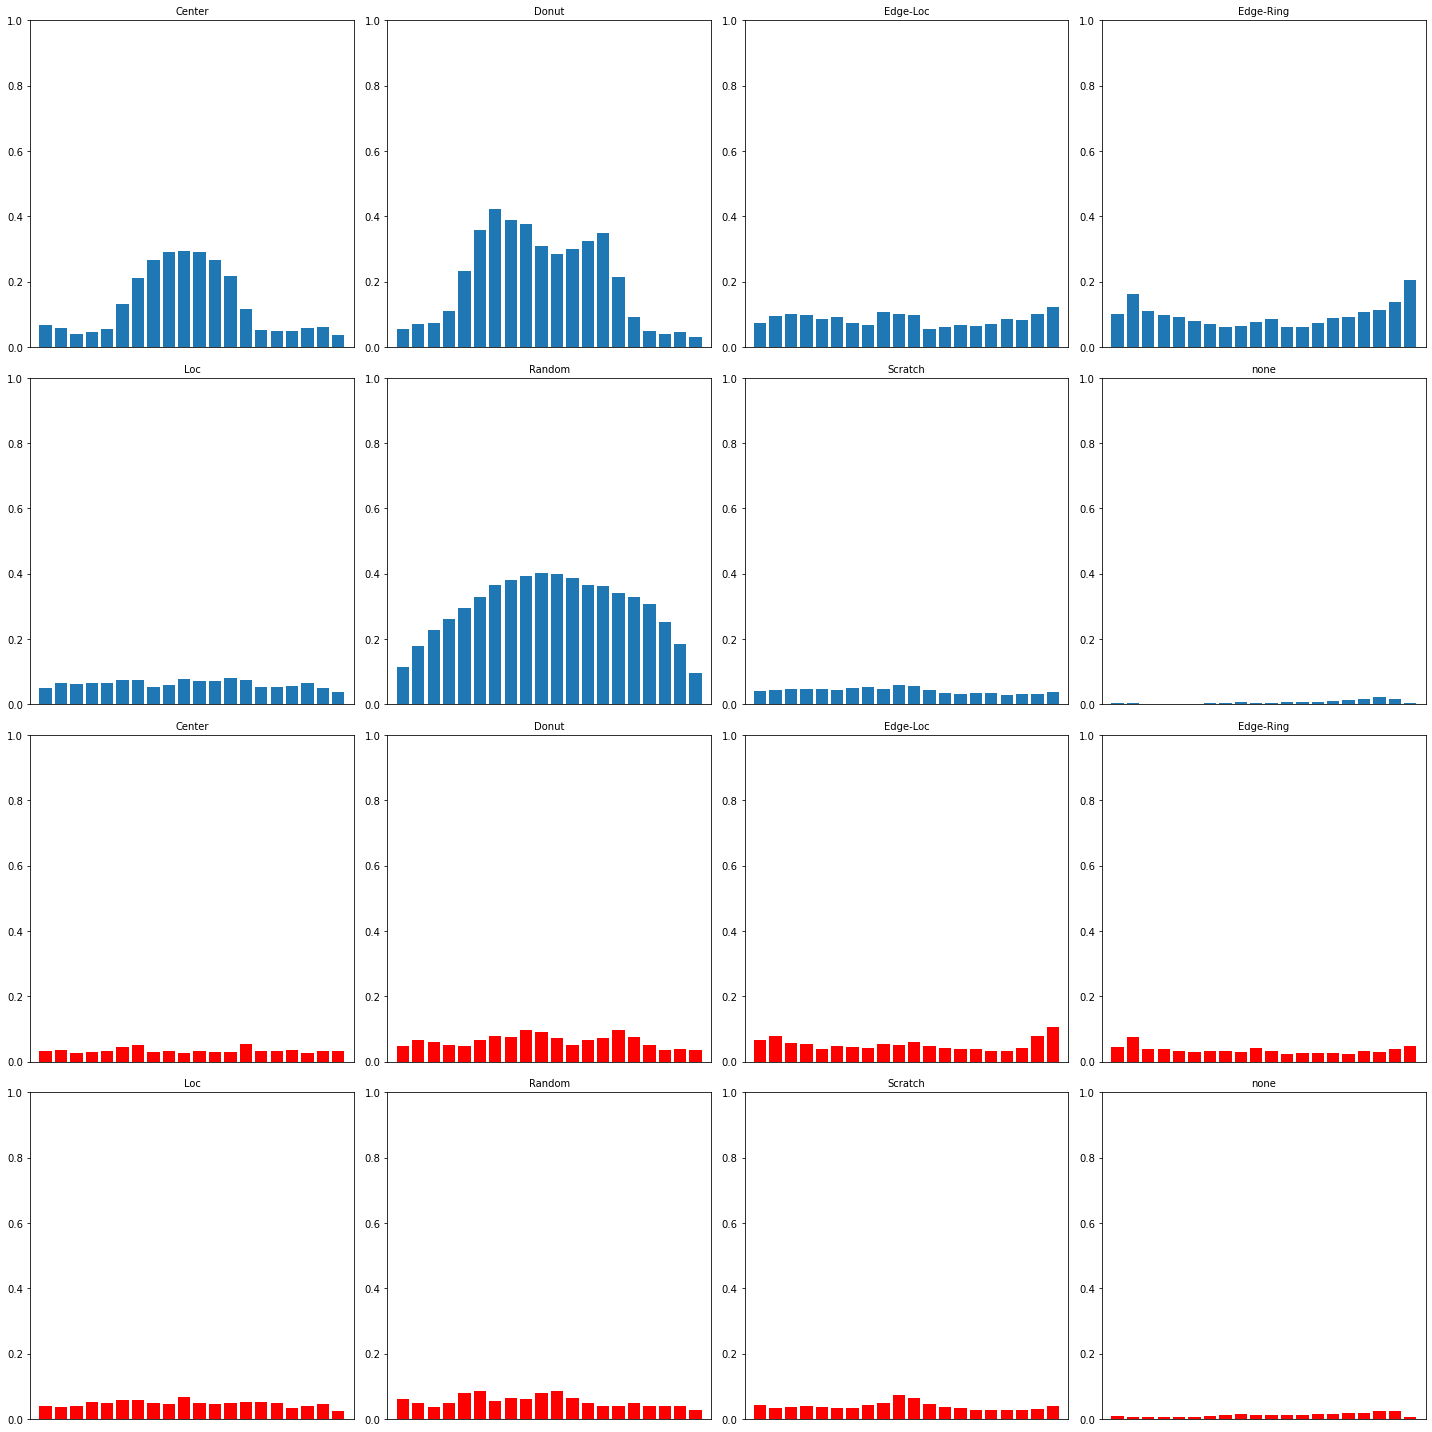

In [32]:
# Visualize adon-based feature (interpolated from row mean and row standard deviation)

fig, ax = plt.subplots(nrows = 4, ncols = 4,figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(num_cat):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    # Row mean
    img = list(sample['fea_cub_mean'])[0]
    ax[i].bar(np.linspace(1,20,20), img)
    ax[i].set_title(cat, fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,1])
    # Row standard deviation
    img = list(sample['fea_cub_std'])[0]
    ax[i+num_cat].bar(np.linspace(1,20,20), img, color = 'r')
    ax[i+num_cat].set_title(cat, fontsize=10)
    ax[i+num_cat].set_xticks([])
    ax[i+num_cat].set_xlim([0,21])   
    ax[i+num_cat].set_ylim([0,1])
plt.tight_layout()
plt.show() 

### 5.3 Geometry-based Features (6)

Geometry-based features define the geometric attributes of the wafer map. We used a region-labeling algorithm and selected the maximal area region as the most salient region which is proposed in a study. The figure below represents the most salient region with the max area for each WM defect class in random samples. It also shows that only the actual defect patterns are visible and all other noises on each WM are removed. Based on the salient region, we try to extract 6 geometry features:

- Perimeter: the perimeter of the most salient region
- Area: area of the most salient region
- Length of minor axes: length of minor axes of the guessed eclipses surrounding the max area salient region
- Length of major axes: length of major axes of the guessed eclipses surrounding the max area salient region
- Solidity: the proportion of defective dice in the guessed convex hull in the max area salient region
- Eccentricity: the outline of the guessed eclipse surrounding the max area salient region

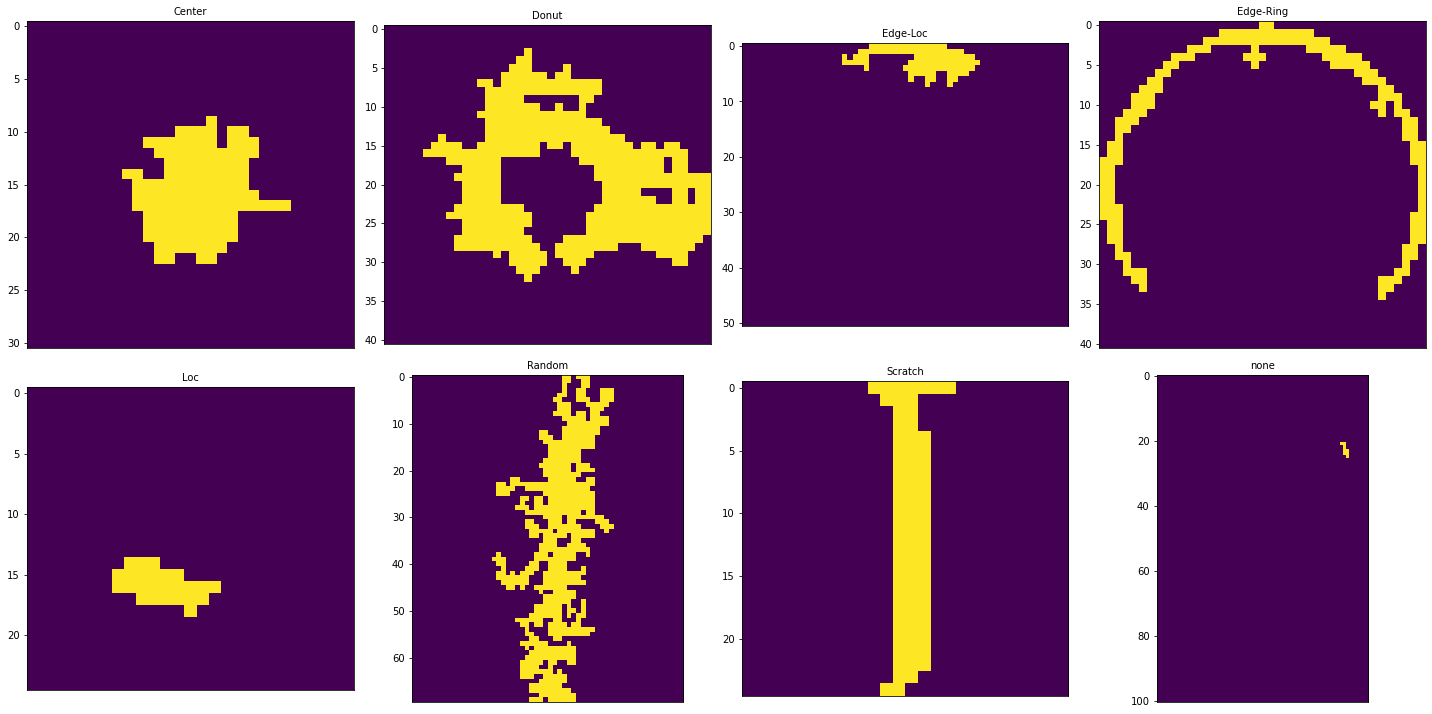

In [33]:
# Visualize salient regions

from skimage import measure
from scipy import stats

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    cat = df3['failureType'].cat.categories[i]
    sample = df3.loc[df['failureType'] == cat].sample(sample_size)
    img = list(sample['waferMap'])[0]
    zero_img = np.zeros(img.shape)
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)
    img_labels = img_labels-1
    if img_labels.max()==0:
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)
        no_region = info_region[0]
    
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(cat, fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show()

In [34]:
# Define functions for calculating geometric features

def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df3['fea_geom'] = df3.waferMap.apply(fea_geom)

## 5.4. Combining extracted features

Since we have extracted multi-type features such as twenty density-based features, six geometry-based features, and forty radon-based features for each WM, next step is to combine all these features. As each feature represents a specific parameter of different wafer defects, their combination can play a vital role in defect identification. Thus, we have a total of 59 (i.e., 13+6+40 = 59) effective features for each WM, which we used for ML analysis. 

In [35]:
# Combine the features

df_all=df3.copy()
a=[df_all.fea_reg.iloc[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean.iloc[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std.iloc[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom.iloc[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [36]:
# Create target column array

label=[df_all.failureNum.iloc[i] for i in range(df_all.shape[0])]
label=np.array(label)

## 6. Machine Learning Classifiers

We will be experimenting with different machine learning classifiers:
- Support Vector Machine (SVM)
- Logistic Regressio (LR)
- Random Forest Classifier

First let's split the train and test sets:

In [37]:
# Split training and testing sets

import theano
from theano import tensor as T
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Training target statistics: Counter({5.0: 389, 6.0: 384, 8.0: 381, 1.0: 380, 3.0: 376, 4.0: 370, 2.0: 367, 0.0: 353})
Testing target statistics: Counter({0.0: 147, 2.0: 133, 4.0: 130, 3.0: 124, 1.0: 120, 8.0: 119, 6.0: 116, 5.0: 111})


### 6.1. Support Vector Machine

This module implements a multiclass and multilabel learning algorithm, and we chose One-VS-One multi-class SVMs as our model based on literature review for this dataset.

- one-vs-the-rest : one-vs-the-rest strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes
- one-vs-one: one-vs-one classifier constructs one classifier per pair of classes.

In [38]:
# Implement OnevsOneClassifier

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score

SVM = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)
y_train_pred = SVM.predict(X_train)
y_test_pred = SVM.predict(X_test)
scores = cross_val_score(SVM, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for Support Vector Machine: \n {scores.mean()}")

Accuracy score for Support Vector Machine: 
 0.696


In [39]:
# Define function to present results

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    labels = failure_types
    plt.xticks(ticks = range(8), labels = labels)
    plt.yticks(ticks = range(8), labels = labels)

Confusion matrix, without normalization
Normalized confusion matrix


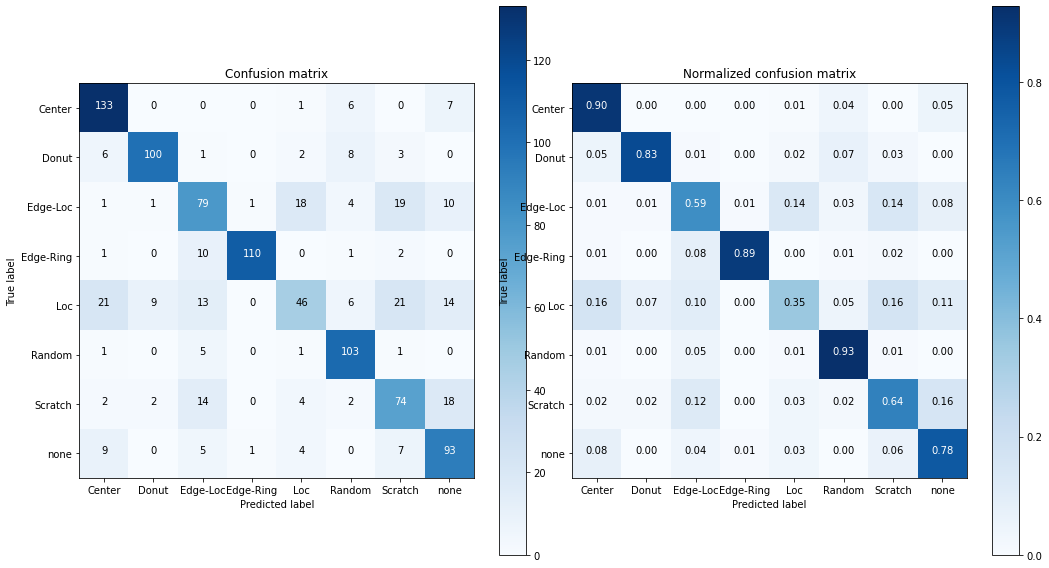

In [40]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### 6.2 Logistic Regression

In [41]:
# Implement logistic regression

from sklearn.linear_model import LogisticRegression

LR = LogisticRegression().fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
scores = cross_val_score(LR, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for the logistic regression: \n {scores.mean()}")

Accuracy score for the logistic regression: 
 0.633


Confusion matrix, without normalization
Normalized confusion matrix


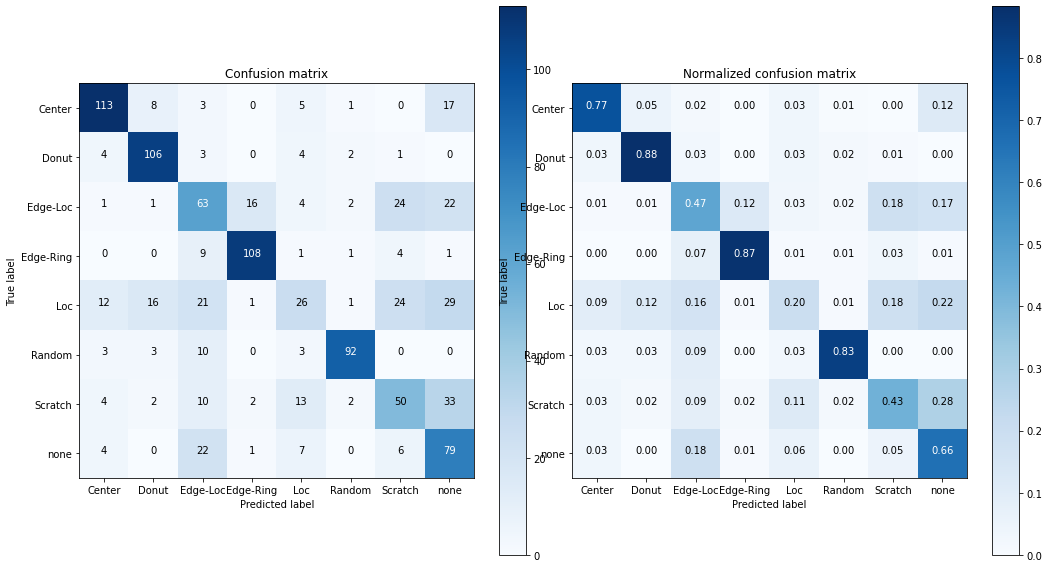

In [42]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### 6.3. Random Forest Classifier

In [43]:
# Implement random forest classifier

from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier().fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)
scores = cross_val_score(RF, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for the random forest classifier: \n {scores.mean()}")

Accuracy score for the random forest classifier: 
 0.8089999999999999


Confusion matrix, without normalization
Normalized confusion matrix


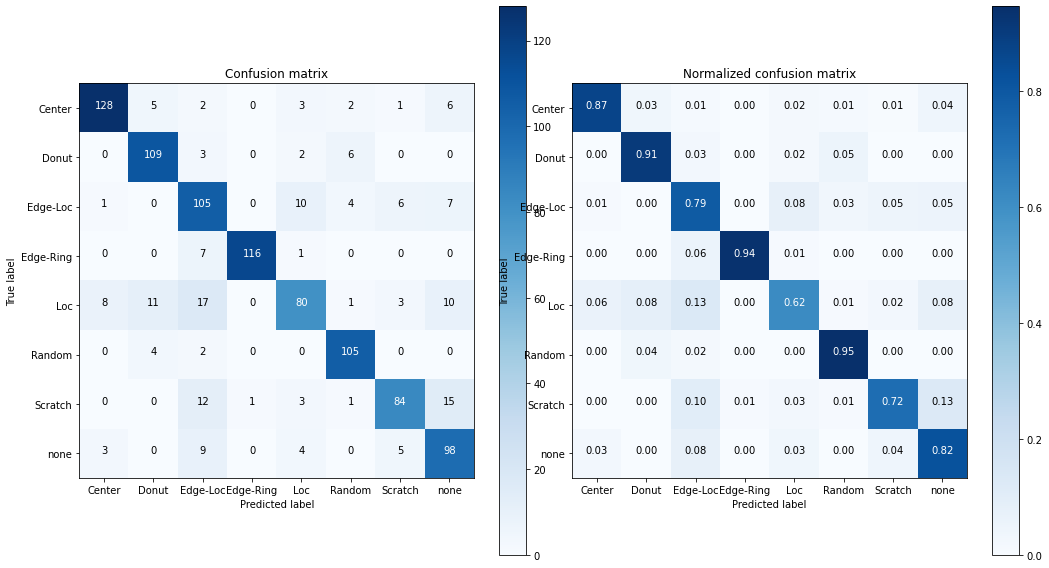

In [44]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

### 6.4. Hyperparameter Tuning for Random Forest Classifier

From the accuracy scores and confusion matrices shown above for the three different algotithms, we see that the random forest classifier obtained the best performace. Therefore, we will now conduct hyperparameter tuning on the random forest classifier to improve the accuracy score.

In [45]:
# Look at parameters used by our current forest

from pprint import pprint
print('Parameters currently in use:\n')
pprint(RF.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [46]:
# Hyperparemeer tuning using grid search

from sklearn.model_selection import GridSearchCV

n_estimators = [100, 300, 500]
max_depth = [30, 40, 50]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 
random.seed(10)
hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [54]:
# Look at the best parameters

best = gridF.best_params_
print(best)

{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [50]:
# Implement random forest classifier with new parameters

RF = RandomForestClassifier(max_depth = best['max_depth'],
     min_samples_leaf = best['min_samples_leaf'],
     min_samples_split = best['min_samples_split],
     n_estimators = best['n_estimators'].fit(X_train, y_train)
y_train_pred = RF.predict(X_train)
y_test_pred = RF.predict(X_test)
scores = cross_val_score(RF, X_test, y_test, cv=10, scoring='accuracy')
print(f"Accuracy score for random forest classifier: \n {scores.mean()}")

Accuracy score for random forest classifier: 
 0.8150000000000001


Confusion matrix, without normalization
Normalized confusion matrix


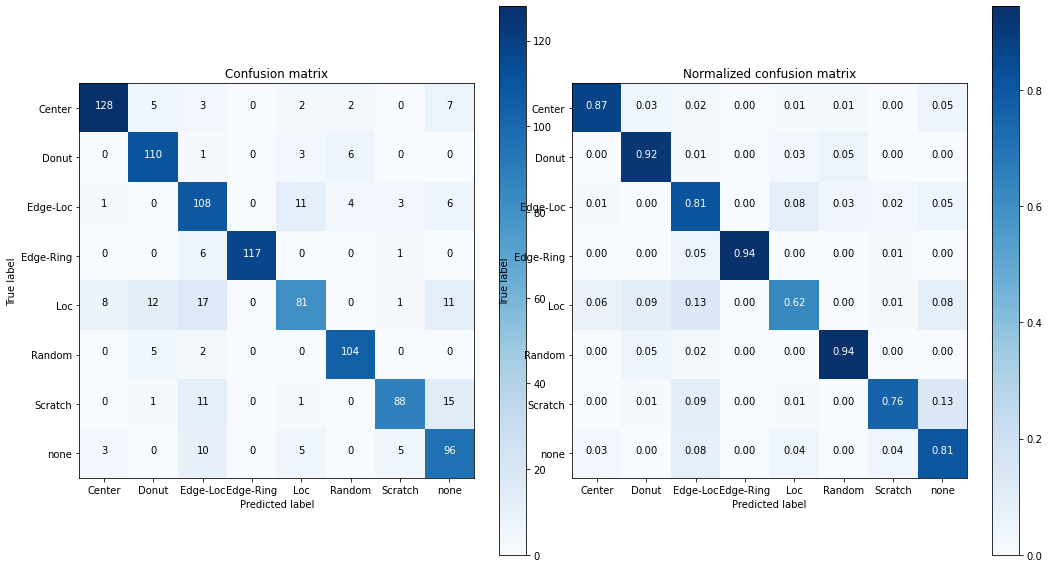

In [56]:
# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix

plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix

plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.show()

## 7. Conclusion

In this project, we developed a defect pattern classification method using a random forest classifier with an accuracy score of 0.792. A random forest classifier is an ensemble learning method for classification that operates by constructing a multitude of decision trees at training time. Among the different wafer defect types, the proposed method achieves the highest accuracy in detecting wafer maps with random, edge-ring, and donut defects. We conducted hyperparameter tuning to discover the best model. This is achieved with feature engineering, where the wafer map attributes are decomposed and aggregated to generate density-based, randon-based, and geometry-based attributes.

## References

https://www.mdpi.com/2076-3417/11/20/9769/htm#B1-applsci-11-09769

https://ieeexplore.ieee.org/document/8293829

https://ieeexplore.ieee.org/document/9442689

https://ieeexplore.ieee.org/document/8664594

http://mirlab.org/dataSet/public/